<a href="https://colab.research.google.com/github/sarjakpatel/SJSU/blob/main/CMPE%20255/Assignment%203/CMPE_255_Approximate_Nearest_Neighbor(ANN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 255 Approximate Nearest Neighbor(ANN)

## Importing the Libraries

In [149]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [150]:
! pip install nmslib

In [151]:
! pip install faiss

In [152]:
!apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [153]:
! pip install annoy

## Loading and Understanding the Dataset

In [154]:
digits = load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
X.shape

(901, 64)

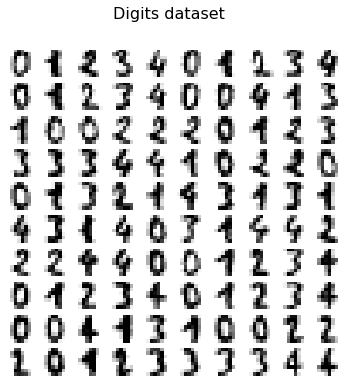

In [155]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Digits dataset", fontsize=16)

## Transforming the Data

In [156]:
#here we reduced our image data that contains 64 features into 2 features using TSNE
from sklearn.manifold import TSNE

tsne_2 = TSNE()
data_embeddings_tsne_2 = tsne_2.fit_transform(X)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [157]:
data_embeddings_tsne_2.shape

(901, 2)

##a) Hierarchical Navigable Small Worlds (HNSW)

In [158]:
import nmslib

In [159]:
hnsw_index = nmslib.init(method='hnsw', space='cosinesimil')
hnsw_train_time = time()
hnsw_index.addDataPointBatch(data_embeddings_tsne_2)
hnsw_index.createIndex({'post': 2})
hnse_train_time = time() - hnsw_train_time

In [160]:
hnsw_search_time = time()
hnsw_output_1 = hnsw_index.knnQuery(data_embeddings_tsne_2[80], k=10)
hnsw_search_time = time() - hnsw_search_time
hnsw_output_list_1 = [y[i] for i in hnsw_output_1[0]]
hnsw_output_list_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [161]:
print("Time taken to feed data into HNSW : ",hnsw_train_time)
print("Time taken to search into HNSW : ",hnsw_search_time)

Time taken to feed data into HNSW :  1638086075.3895752
Time taken to search into HNSW :  0.00014328956604003906


In [162]:
y[80] #here as you can see that input image we gave above is number 0.

0

In [163]:
hnsw_output_2 = hnsw_index.knnQuery(data_embeddings_tsne_2[90], k=10)
hnsw_output_list_2 = [y[i] for i in hnsw_output_2[0]]
hnsw_output_list_2

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [164]:
y[90] #here as you can see that input image we gave above is number 2.

2

Here, in above 2 examples as we can see that we feed image vectors into HNSW and we search for any one particular number(vector) and HNSW gives us that list of numbers(vectors) which is similar to our input image(vector).

## b) Exhaustive Search

In [165]:
import faiss

In [166]:
exhaustive_search = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
exhaustive_train_time = time()
exhaustive_search.add(data_embeddings_tsne_2)
exhaustive_train_time = time() - exhaustive_train_time

In [167]:
exhaustive_search_time = time()
distances, indices = exhaustive_search.search(data_embeddings_tsne_2[80:81], 10)
exhaustive_search_time = time() - exhaustive_search_time
exhaustive_search_output_list_1 = [y[i] for i in indices[0]]
exhaustive_search_output_list_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [168]:
print("Time taken to feed data into Exhaustive Search : ",exhaustive_train_time)
print("Time taken to search into Exhaustive Search : ",exhaustive_search_time)

Time taken to feed data into Exhaustive Search :  0.0034046173095703125
Time taken to search into Exhaustive Search :  0.00410151481628418


In [169]:
y[80] #here as you can see that input image we gave above is number 0.

0

In [170]:
distances, indices = exhaustive_search.search(data_embeddings_tsne_2[90:91], 10) 
exhaustive_search_output_list_2 = [y[i] for i in indices[0]]
exhaustive_search_output_list_2

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [171]:
y[90] #here as you can see that input image we gave above is number 2.

2

Here, in above 2 examples as we can see that we feed image vectors into exhaustive search method and we search for any one particular number(vector) and exhaustive search method gives us that list of numbers(vectors) which is similar to our input image(vector).

##c) Product Quantization

In [172]:
number_of_partition = 8
search_in_x_partitions = 2
subvector_size = 8

pq_quantizer = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
pq = faiss.IndexIVFPQ(pq_quantizer, data_embeddings_tsne_2.shape[1], number_of_partition, search_in_x_partitions, subvector_size)
pq_train_time = time()
pq.train(data_embeddings_tsne_2)
pq.add(data_embeddings_tsne_2)
pq_train_time = time() - pq_train_time

In [173]:
pq_search_time = time()
distances, indices = pq.search(data_embeddings_tsne_2[80:81], 10)
pq_search_time = time() - pq_search_time 
pq_output_list_1 =  [y[i] for i in indices[0]]
pq_output_list_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [174]:
print("Time taken to feed data into Product Quantization : ",pq_train_time)
print("Time taken to search into Product Quantization : ",pq_search_time)

Time taken to feed data into Product Quantization :  0.12990760803222656
Time taken to search into Product Quantization :  0.0014691352844238281


In [175]:
y[80] #here as you can see that input image we gave above is number 0.

0

In [176]:
distances, indices = pq.search(data_embeddings_tsne_2[90:91], 10) 
pq_output_list_2 =  [y[i] for i in indices[0]]
pq_output_list_2

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [177]:
y[90] #here as you can see that input image we gave above is number 2.

2

Here, in above 2 examples as we can see that we feed image vectors into product quantization method and we search for any one particular number(vector) and product quantization method gives us that list of numbers(vectors) which is similar to our input image(vector).

## d) Locality Sensitive Hashing (LSH)

In [178]:
lsh = faiss.IndexLSH(data_embeddings_tsne_2.shape[1], 10)
lsh_train_time = time()
lsh.add(data_embeddings_tsne_2)
lsh_train_time = time() - lsh_train_time

In [179]:
lsh_search_time = time()
distances, indices = lsh.search(data_embeddings_tsne_2[80:81], k=10)
lsh_search_time = time() - lsh_search_time
lsh_output_list_1 =  [y[i] for i in indices[0]]
lsh_output_list_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [180]:
print("Time taken to feed data into Locality Sensitive Hashing (LSH) : ",lsh_train_time)
print("Time taken to search into Locality Sensitive Hashing (LSH) : ",lsh_search_time)

Time taken to feed data into Locality Sensitive Hashing (LSH) :  0.0006318092346191406
Time taken to search into Locality Sensitive Hashing (LSH) :  0.002503633499145508


In [181]:
y[80] #here as you can see that input image we gave above is number 0.

0

In [182]:
distances, indices = lsh.search(data_embeddings_tsne_2[90:91], k=10)
lsh_output_list_2 =  [y[i] for i in indices[0]]
lsh_output_list_2

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [183]:
y[90] #here as you can see that input image we gave above is number 2.

2

Here, in above 2 examples as we can see that we feed image vectors into LSH method and we search for any one particular number(vector) and LSH method gives us that list of numbers(vectors) which is similar to our input image(vector).

## e) Trees and Graphs

Part 1. Trees

In [184]:
import annoy

In [185]:
number_of_trees = 5
annoy_index = annoy.AnnoyIndex(data_embeddings_tsne_2.shape[1])
trees_train_time = time()
for i, vec in enumerate(data_embeddings_tsne_2):
  annoy_index.add_item(i, vec.tolist())
annoy_index.build(number_of_trees)
trees_train_time = time() - trees_train_time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


In [186]:
trees_search_time = time()
annoy_indices = annoy_index.get_nns_by_vector(data_embeddings_tsne_2[80].tolist(), 10)
trees_search_time = time() - trees_search_time
annoy_output_list_1 = [y[i] for i in annoy_indices]
annoy_output_list_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [187]:
print("Time taken to feed data into Trees : ",trees_train_time)
print("Time taken to search into Trees : ",trees_search_time)

Time taken to feed data into Trees :  0.06620383262634277
Time taken to search into Trees :  0.0016701221466064453


In [188]:
y[80] #here as you can see that input image we gave above is number 2.

0

In [189]:
annoy_indices = annoy_index.get_nns_by_vector(data_embeddings_tsne_2[90].tolist(), 10)
annoy_output_list_2 = [y[i] for i in annoy_indices]
annoy_output_list_2

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [190]:
y[90] #here as you can see that input image we gave above is number 2.

2

Part 2: Graphs

In [191]:
graph_index = faiss.IndexHNSWFlat(data_embeddings_tsne_2.shape[1], 10)
graph_train_time = time()
graph_index.add(data_embeddings_tsne_2)
graph_train_time = time() - graph_train_time

In [192]:
graph_search_time = time()
distances, indices = graph_index.search(data_embeddings_tsne_2[80:81], k=10)
graph_search_time = time() - graph_search_time
graph_output_list_1 = [y[i] for i in indices[0]]
graph_output_list_1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [193]:
print("Time taken to feed data into Graphs : ",graph_train_time)
print("Time taken to search into Graphs : ",graph_search_time)

Time taken to feed data into Graphs :  0.01867389678955078
Time taken to search into Graphs :  0.001573801040649414


In [194]:
y[80]

0

In [195]:
distances, indices = graph_index.search(data_embeddings_tsne_2[90:91], k=10)
graph_output_list_2 = [y[i] for i in indices[0]]
graph_output_list_2

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [196]:
y[90]

2

Here, in above 2 examples as we can see that we feed image vectors into trees and graphs method and we search for any one particular number(vector) and trees and graphs method gives us that list of numbers(vectors) which is similar to our input image(vector).

In [197]:
print("Time taken to feed data into HNSW : ",hnsw_train_time)
print("Time taken to feed data into Exhaustive Search : ",exhaustive_train_time)
print("Time taken to feed data into Product Quantization : ",pq_train_time)
print("Time taken to feed data into Locality Sensitive Hashing (LSH) : ",lsh_train_time)
print("Time taken to feed data into Trees : ",trees_train_time)
print("Time taken to feed data into Graphs : ",graph_train_time)

Time taken to feed data into HNSW :  1638086075.3895752
Time taken to feed data into Exhaustive Search :  0.0034046173095703125
Time taken to feed data into Product Quantization :  0.12990760803222656
Time taken to feed data into Locality Sensitive Hashing (LSH) :  0.0006318092346191406
Time taken to feed data into Trees :  0.06620383262634277
Time taken to feed data into Graphs :  0.01867389678955078


In [198]:
print("Time taken to search into HNSW : ",hnsw_search_time)
print("Time taken to search into Exhaustive Search : ",exhaustive_search_time)
print("Time taken to search into Product Quantization : ",pq_search_time)
print("Time taken to search into Locality Sensitive Hashing (LSH) : ",lsh_search_time)
print("Time taken to search into Trees : ",trees_search_time)
print("Time taken to search into Graphs : ",graph_search_time)

Time taken to search into HNSW :  0.00014328956604003906
Time taken to search into Exhaustive Search :  0.00410151481628418
Time taken to search into Product Quantization :  0.0014691352844238281
Time taken to search into Locality Sensitive Hashing (LSH) :  0.002503633499145508
Time taken to search into Trees :  0.0016701221466064453
Time taken to search into Graphs :  0.001573801040649414


As you can see from the above results,
  
*   HNSW takes longer time to feed the data for NMSLIB method, but it takes less time for searching and it also supports batch  queries.
*   Product Quantization method takes second highest time to feed the data as it uses less memory and it performs good in the searching.

*  Locality Sensitive Hashing (LSH) takes very less time to feed the data, and also takes less time for searching. but it needs more RAM. 




